# Evaluating Matching Report Files

In [1]:
%matplotlib inline

import os
import sys
import json
import warnings

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as snb

from sklearn import metrics

In [2]:
pd.set_option('display.max_rows', 512)
snb.set(style='whitegrid')

In [3]:
solution_file = '/mnt/files/Workspace/datasets/painter-by-numbers/meta/solution_painter.csv'
submission_info_file = '/mnt/files/Workspace/datasets/painter-by-numbers/meta/submission_info.csv'
info_file = '/mnt/files/Workspace/datasets/painter-by-numbers/meta/all_data_info.csv'
train_info_file = '/mnt/files/Workspace/datasets/painter-by-numbers/meta/train_info.csv'

labels = ['different-artist', 'same-artist']

strategy = 'mean'

TOTAL_ANSWERS = 21916047
USED_ANSWERS = 1.0

info_features = 'artist_group artist_name style genre source date'.split()

In [53]:
answers_dir = '/mnt/files/Workspace/logs/painter-by-numbers/submitted'
answers = [os.path.join(answers_dir, a) for a in os.listdir(answers_dir)]
answers

['/mnt/files/Workspace/logs/painter-by-numbers/submitted/multi-task.csv',
 '/mnt/files/Workspace/logs/painter-by-numbers/submitted/multi-label.csv',
 '/mnt/files/Workspace/logs/painter-by-numbers/submitted/cos.csv']

### Reading Solution and Submission Info

In [4]:
import hashlib

def load_info(all_info_path, train_info_path):
    info = pd.read_csv(all_info_path).rename(columns={'new_filename': 'filename', 'artist': 'artist_name'})
    train_info = (pd.read_csv(train_info_path)
                  .drop(columns='title style genre date'.split())
                  .rename(columns={'artist': 'artist_hash'})
                  .set_index('filename'))

    info = info.merge(train_info, on='filename', how='left')

    info['artist_name'] = info.artist_name.str.strip().astype('str')
    info['date'] = (info.date
                  .str.lstrip(r'c\.|(January|February|March|April|May|September|October|November|December)\s')
                  .str.replace('fic', 'nan', regex=False)
                  .str.replace(r'^$', 'nan', regex=True)
                  .astype(float))

    artists_w_hash = info[~info.artist_hash.isna()][['artist_name', 'artist_hash']].drop_duplicates()
    artists_map = dict(zip(artists_w_hash.artist_name, artists_w_hash.artist_hash))

    hashes = info.artist_hash.copy()
    hashes[hashes.isna()] = info.artist_name.map(lambda n: artists_map.get(n, hashlib.md5(n.encode()).hexdigest()))[hashes.isna()]
    info['artist_hash'] = hashes

    return info

info = load_info(info_file, train_info_file)

In [5]:
solution, submission = map(pd.read_csv, (solution_file, submission_info_file))

[f.set_index('index', inplace=True) for f in [solution, submission]]
info.set_index('filename', inplace=True)

In [6]:
answer = (
  pd
  .read_csv(answers[0])
  .set_index('index'))

if USED_ANSWERS < 1:
    answer = answer.sample(frac=USED_ANSWERS)

z = submission.join(solution, how='left')
z = answer.join(z, how='left', lsuffix='_answer')

z = pd.merge(z, info[info_features], left_on='image1', right_on='filename', how='left')
z = pd.merge(z, info[info_features], left_on='image2', right_on='filename', how='left')

In [7]:
print(f'{answer.shape} x {submission.shape} x {solution.shape} --> {z.shape}')

(21916047, 1) x (21916047, 2) x (21916047, 1) --> (21916047, 16)


In [8]:
def as_percentage(df, values='values'):
    return df.assign(**{values: df[values] / df[values].sum()})

In [9]:
def metrics_from_subgroup(df, names):
    names = list(names)

    gs = (df[names + ['sameArtist', 'sameArtist_answer']]
        .fillna('unknown')
        .groupby(names))

    results = []

    for name, g in gs:
        probabilities = g.sameArtist_answer
        predictions = (g.sameArtist_answer > 0.5).astype(float)

        try: roc_auc = metrics.roc_auc_score(g.sameArtist, probabilities)
        except: roc_auc = None
        bacc = metrics.balanced_accuracy_score(g.sameArtist, predictions)
        acc = metrics.accuracy_score(g.sameArtist, predictions)

        if isinstance(name, str):
            name = (name,)

        results.append(name + (acc, bacc, roc_auc, len(g)))

    return (pd.DataFrame(results, columns=names + ['Acc', 'B. Acc.', 'ROC AUC', 'Support*'])
            .sort_values('ROC AUC', ascending=False))

## Plotting Scoring

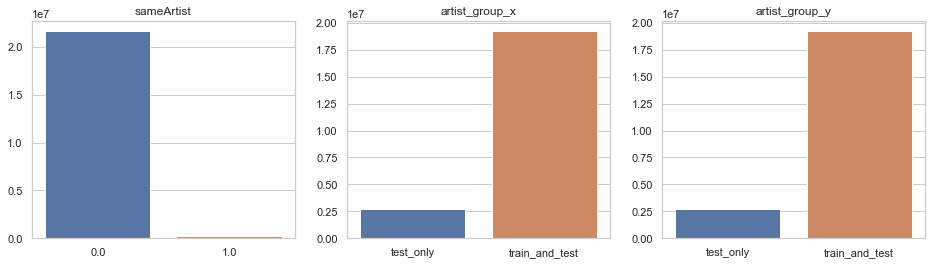

In [30]:
groups = 'sameArtist artist_group_x artist_group_y'.split()

plt.figure(figsize=(16, 4))

for ix, column in enumerate(groups):
    plt.subplot(1, len(groups), ix + 1)
    plt.title(column)

    l, c = np.unique(z[column], return_counts=True)
    snb.barplot(x=l, y=c)

In [10]:
r_source = metrics_from_subgroup(z, ('source_x', 'source_y'))
r_group = metrics_from_subgroup(z, ['artist_group_x', 'artist_group_y'])

r_painter = metrics_from_subgroup(z, ['artist_name_x'])
r_genre = metrics_from_subgroup(z, ['genre_x'])
r_style = metrics_from_subgroup(z, ['style_x'])

/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains

In [11]:
r_genre_style = metrics_from_subgroup(z, ['genre_x', 'style_x'])

/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains

In [12]:
r_source

,source_x,source_y,Acc,B. Acc.,ROC AUC,Support*
4,wikiart,wikiart,0.925401,0.807195,0.918094,19800448
5,wikiart,wikipedia,0.911325,0.709522,0.854017,905438
7,wikipedia,wikiart,0.913906,0.702248,0.850366,940499
8,wikipedia,wikipedia,0.837952,0.708369,0.809728,48029
0,unknown,unknown,0.510638,0.647262,0.747985,1504
1,unknown,wikiart,0.968876,0.968876,NaN,103940
2,unknown,wikipedia,0.962225,0.962225,NaN,5321
3,wikiart,unknown,0.963641,0.963641,NaN,105365
6,wikipedia,unknown,0.946575,0.946575,NaN,5503


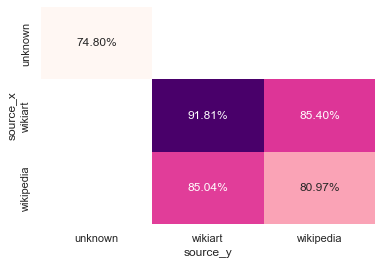

In [13]:
snb.heatmap(
    data=r_source.pivot('source_x', 'source_y', 'ROC AUC'), 
    cbar=False, annot=True, fmt='.2%', cmap="RdPu");

In [14]:
# Multi-label
r_group

,artist_group_x,artist_group_y,Acc,B. Acc.,ROC AUC,Support*
3,train_and_test,train_and_test,0.922996,0.814353,0.922296,16876395
0,test_only,test_only,0.869920,0.697731,0.840157,346578
1,test_only,train_and_test,0.933837,0.933837,NaN,2349142
2,train_and_test,test_only,0.934134,0.934134,NaN,2343932


In [17]:
# Multi-task
r_group

,artist_group_x,artist_group_y,Acc,B. Acc.,ROC AUC,Support*
3,train_and_test,train_and_test,0.910166,0.792032,0.907958,16878820
0,test_only,test_only,0.864185,0.654607,0.818115,347310
1,test_only,train_and_test,0.929356,0.929356,NaN,2349250
2,train_and_test,test_only,0.929114,0.929114,NaN,2340670


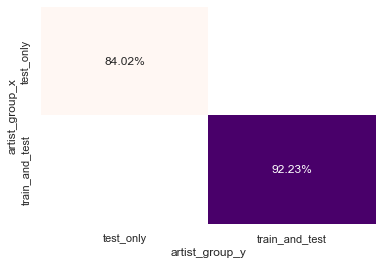

In [15]:
# Multi-label
snb.heatmap(
    data=r_group.pivot('artist_group_x', 'artist_group_y', 'ROC AUC'), 
    cbar=False, annot=True, fmt='.2%', cmap="RdPu");

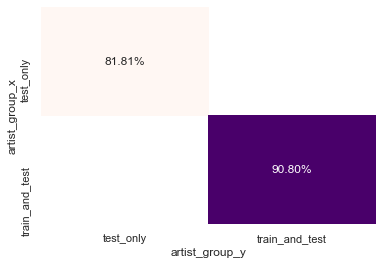

In [18]:
# Multi-task
snb.heatmap(
    data=r_group.pivot('artist_group_x', 'artist_group_y', 'ROC AUC'), 
    cbar=False, annot=True, fmt='.2%', cmap="RdPu");

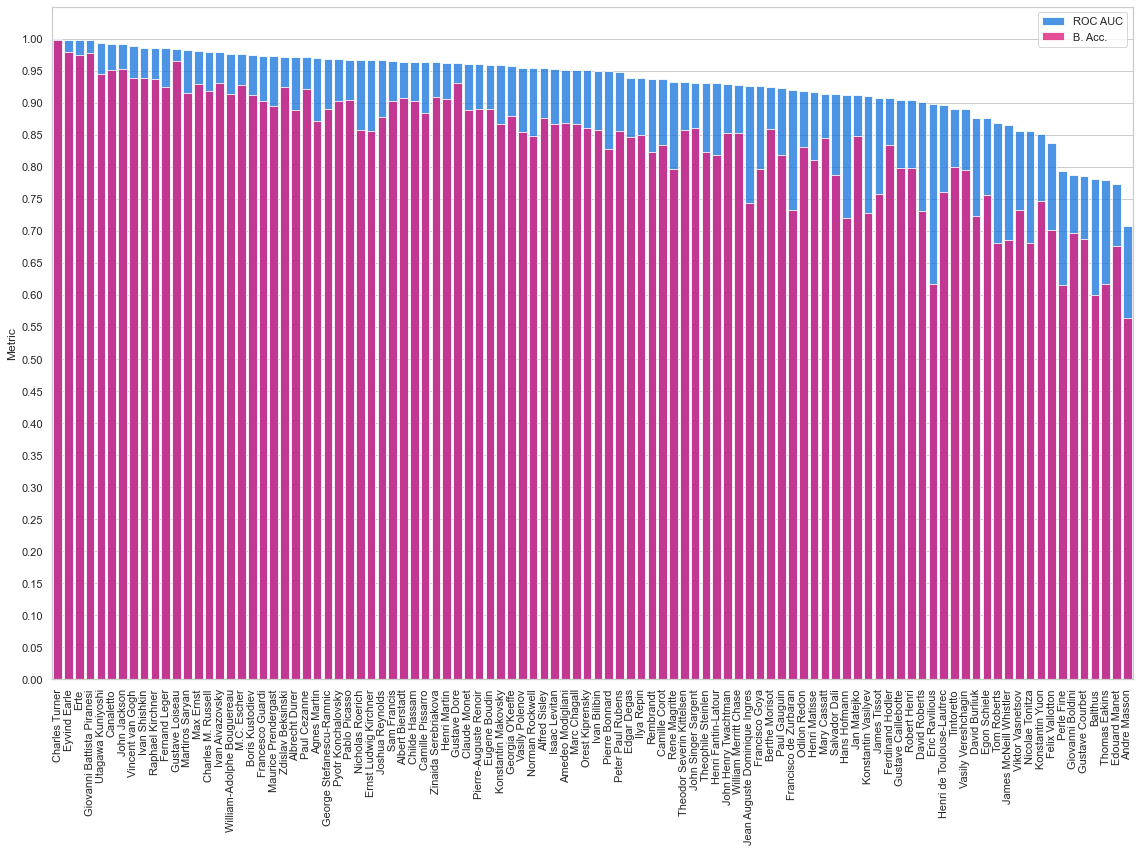

In [16]:
# Multi-label
r_painter_sampled = r_painter.sort_values('Support*', ascending=False)[:100]
r_painter_sampled = r_painter_sampled.sort_values('ROC AUC', ascending=False)

plt.figure(figsize=(16, 12))

snb.barplot(data=r_painter_sampled.dropna(), x='artist_name_x', y='ROC AUC', label='ROC AUC', color='#0077ff', alpha=.8)
snb.barplot(data=r_painter_sampled, x='artist_name_x', y='B. Acc.', label='B. Acc.', color='#ff007b', alpha=.8)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.05))
plt.xlabel(None)
plt.ylabel('Metric')
plt.legend()
plt.tight_layout();

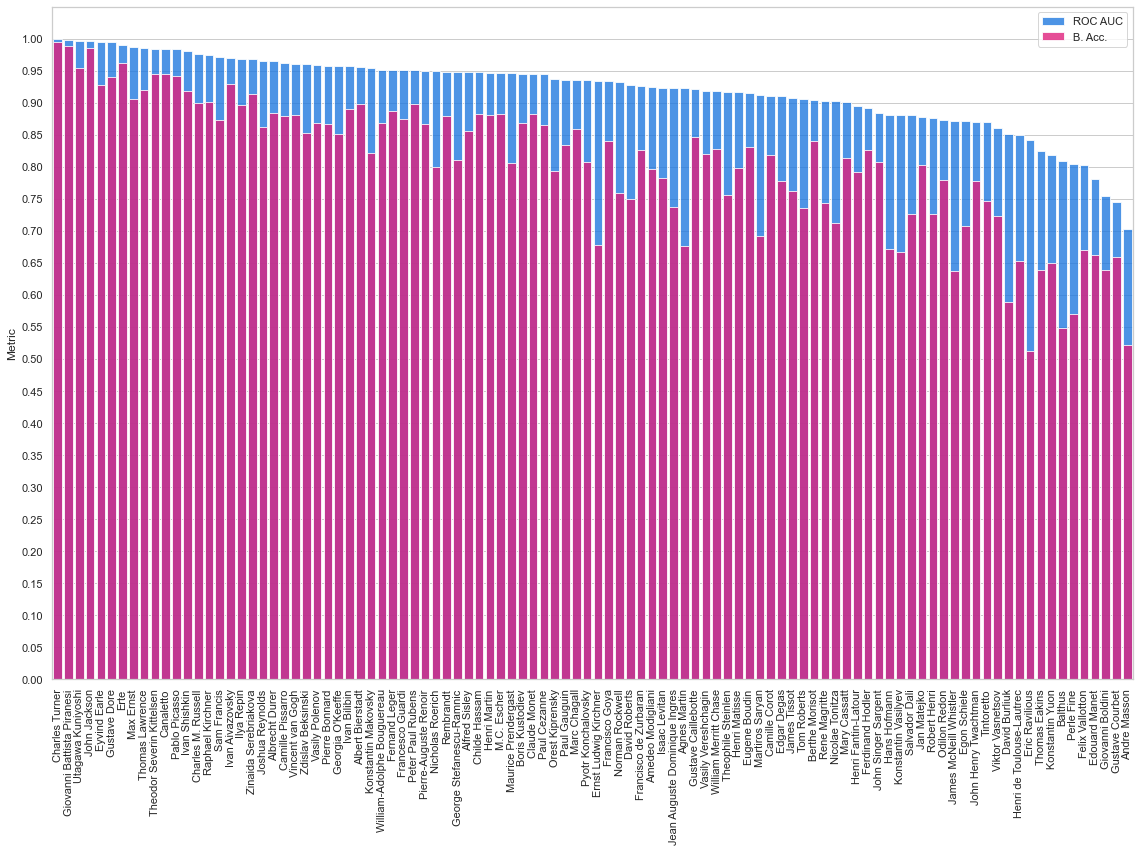

In [19]:
# Multi-task
r_painter_sampled = r_painter.sort_values('Support*', ascending=False)[:100]
r_painter_sampled = r_painter_sampled.sort_values('ROC AUC', ascending=False)

plt.figure(figsize=(16, 12))

snb.barplot(data=r_painter_sampled.dropna(), x='artist_name_x', y='ROC AUC', label='ROC AUC', color='#0077ff', alpha=.8)
snb.barplot(data=r_painter_sampled, x='artist_name_x', y='B. Acc.', label='B. Acc.', color='#ff007b', alpha=.8)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.05))
plt.xlabel(None)
plt.ylabel('Metric')
plt.legend()
plt.tight_layout();
r_painter_sampled = r_painter.sort_values('Support*', ascending=False)[:100]
r_painter_sampled = r_painter_sampled.sort_values('ROC AUC', ascending=False)

plt.figure(figsize=(16, 12))

snb.barplot(data=r_painter_sampled.dropna(), x='artist_name_x', y='ROC AUC', label='ROC AUC', color='#0077ff', alpha=.8)
snb.barplot(data=r_painter_sampled, x='artist_name_x', y='B. Acc.', label='B. Acc.', color='#ff007b', alpha=.8)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.05))
plt.xlabel(None)
plt.ylabel('Metric')
plt.legend()
plt.tight_layout();

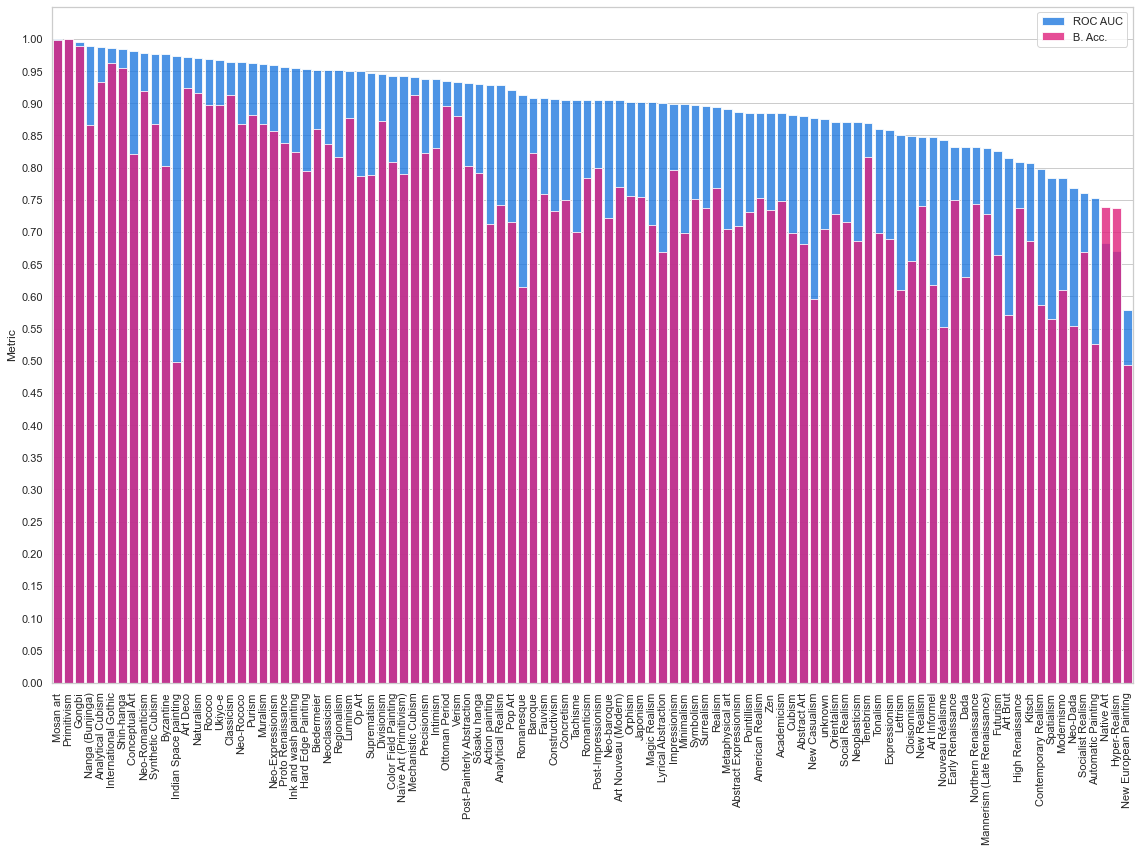

In [70]:
r_style_sampled = r_style.sort_values('Support*', ascending=False)[:100]
r_style_sampled = r_style_sampled.sort_values('ROC AUC', ascending=False)

plt.figure(figsize=(16, 12))

snb.barplot(data=r_style_sampled.dropna(), x='style_x', y='ROC AUC', label='ROC AUC', color='#0077ff', alpha=.8)
snb.barplot(data=r_style_sampled, x='style_x', y='B. Acc.', label='B. Acc.', color='#ff007b', alpha=.8)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.05))
plt.xlabel(None)
plt.ylabel('Metric')
plt.legend()
plt.tight_layout();

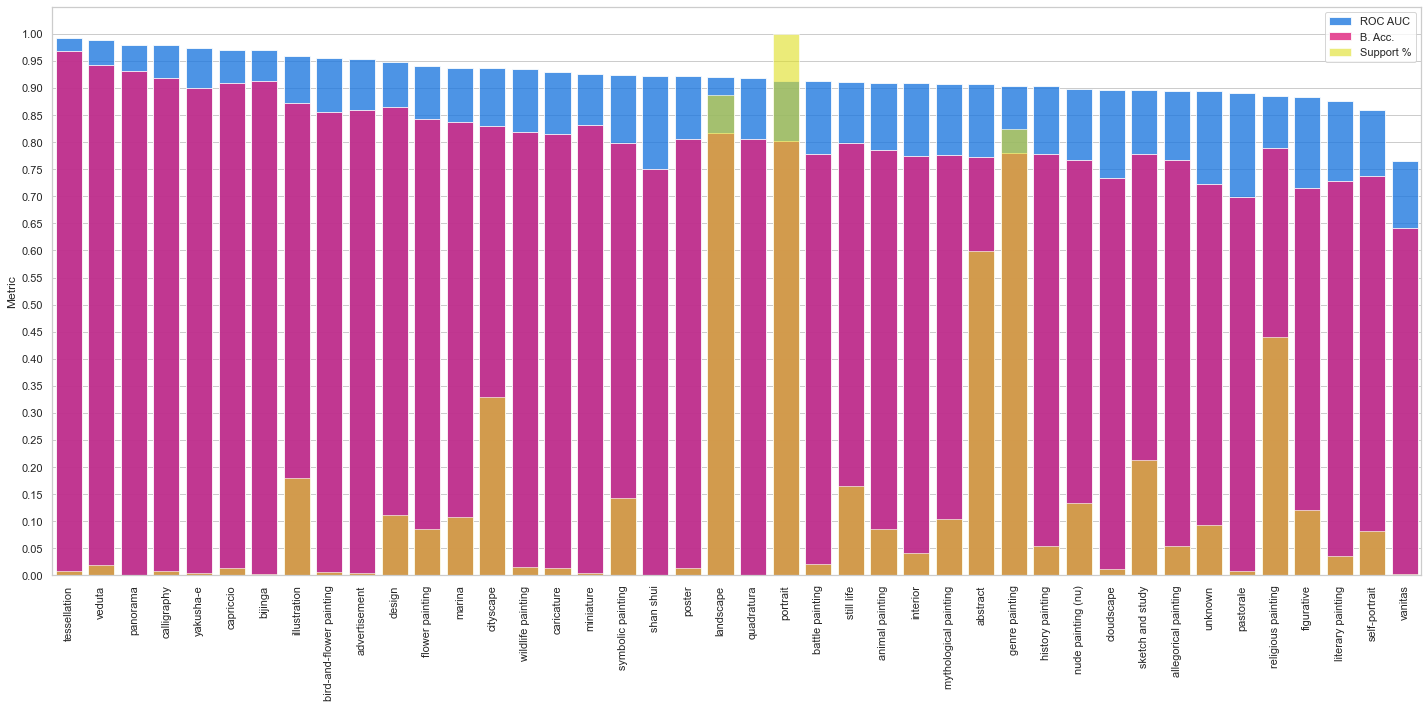

In [17]:
# Multi-label
plt.figure(figsize=(20, 10))

snb.barplot(data=r_genre.dropna(), x='genre_x', y='ROC AUC', label='ROC AUC', color='#0077ff', alpha=0.8)
snb.barplot(data=r_genre, x='genre_x', y='B. Acc.', label='B. Acc.', color='#ff007b', alpha=.8)
snb.barplot(data=r_genre.assign(**{'Support %': r_genre['Support*'] / r_genre['Support*'].max()}),
            x='genre_x', y='Support %', label='Support %', color='yellow', alpha=.6)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.05))
plt.xlabel(None)
plt.ylabel('Metric')
plt.legend()
plt.tight_layout();

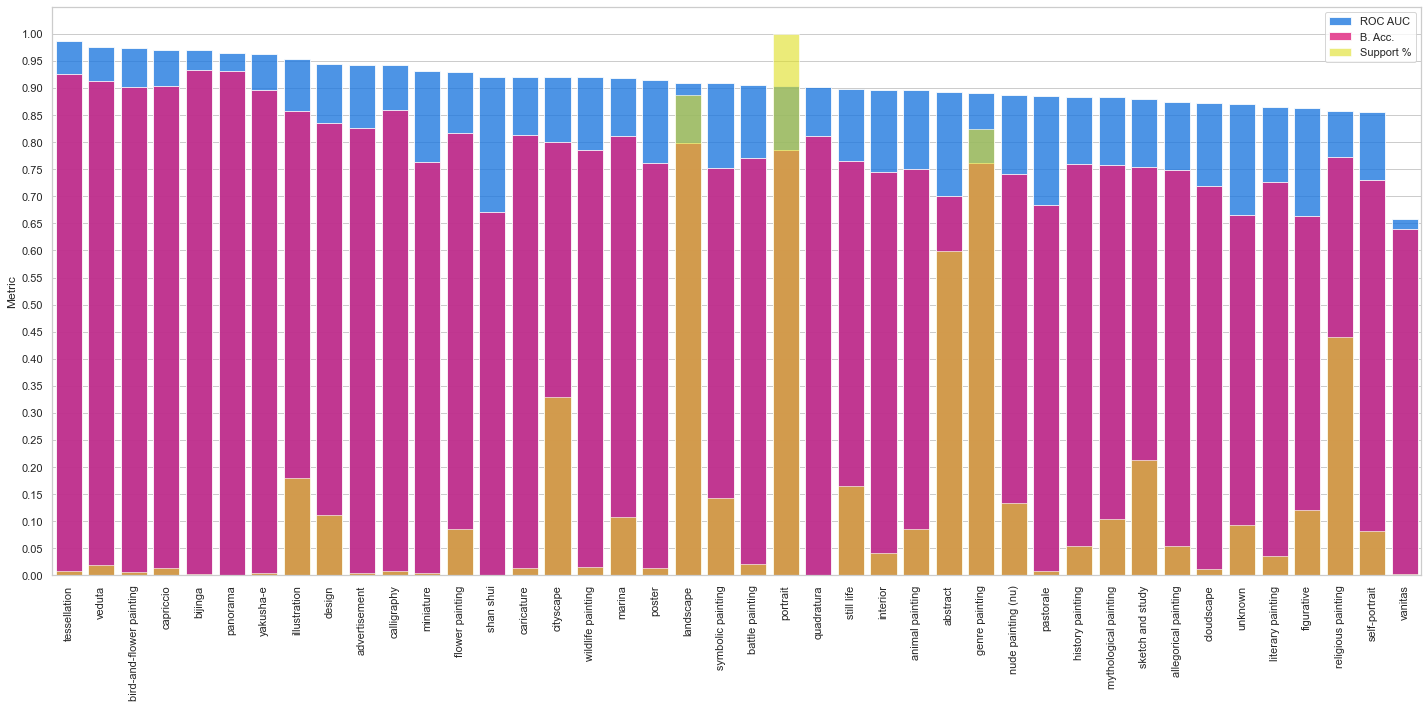

In [11]:
# Multi-task
plt.figure(figsize=(20, 10))

snb.barplot(data=r_genre.dropna(), x='genre_x', y='ROC AUC', label='ROC AUC', color='#0077ff', alpha=0.8)
snb.barplot(data=r_genre, x='genre_x', y='B. Acc.', label='B. Acc.', color='#ff007b', alpha=.8)
snb.barplot(data=r_genre.assign(**{'Support %': r_genre['Support*'] / r_genre['Support*'].max()}),
            x='genre_x', y='Support %', label='Support %', color='yellow', alpha=.6)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.05))
plt.xlabel(None)
plt.ylabel('Metric')
plt.legend()
plt.tight_layout();

In [18]:
r_genre_genre = metrics_from_subgroup(z, ['genre_x', 'genre_y'])

/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains

/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains

/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains

/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains

/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains

/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains

/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains

/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains

/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/files/Workspace/envs/t/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains

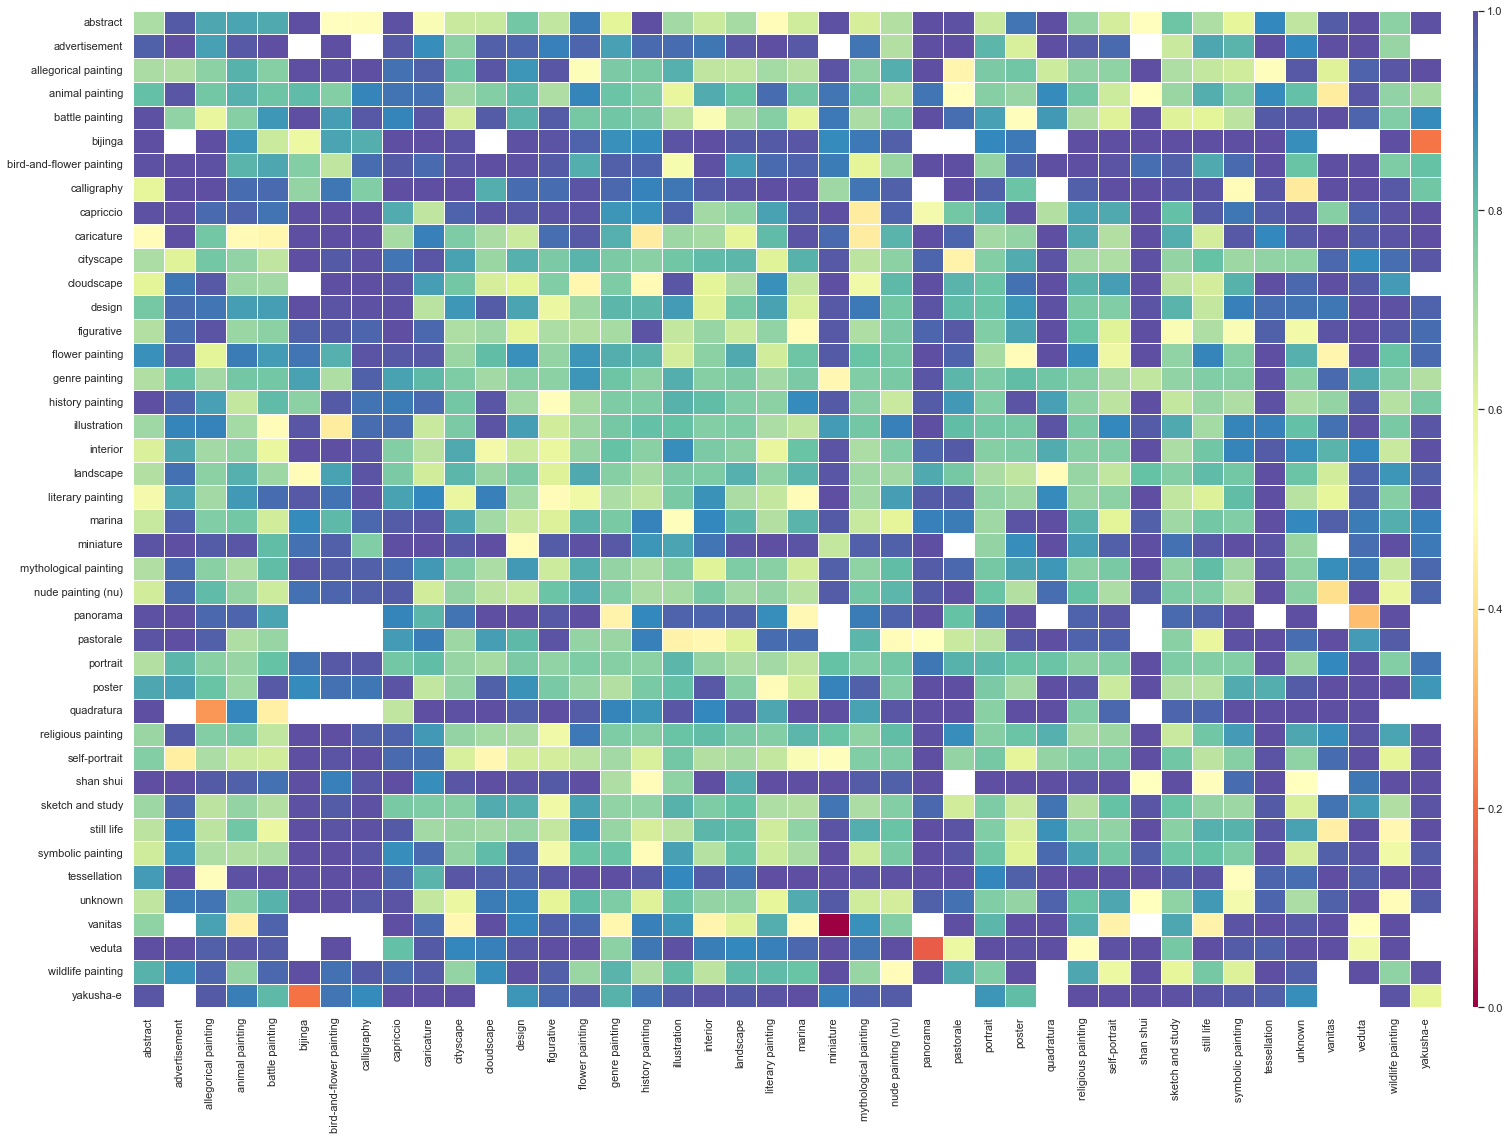

In [19]:
# Multi-label
plt.figure(figsize=(24, 16))
snb.heatmap(
    data=r_genre_genre.pivot('genre_x', 'genre_y', 'B. Acc.'), 
    annot=False, fmt='.0%', cmap="Spectral", cbar=True, linewidths=.5,
    vmin=0, vmax=1, center=0.5, cbar_kws={'aspect': 200, 'pad': 0.02})

plt.ylabel(None); plt.xlabel(None); plt.tight_layout();

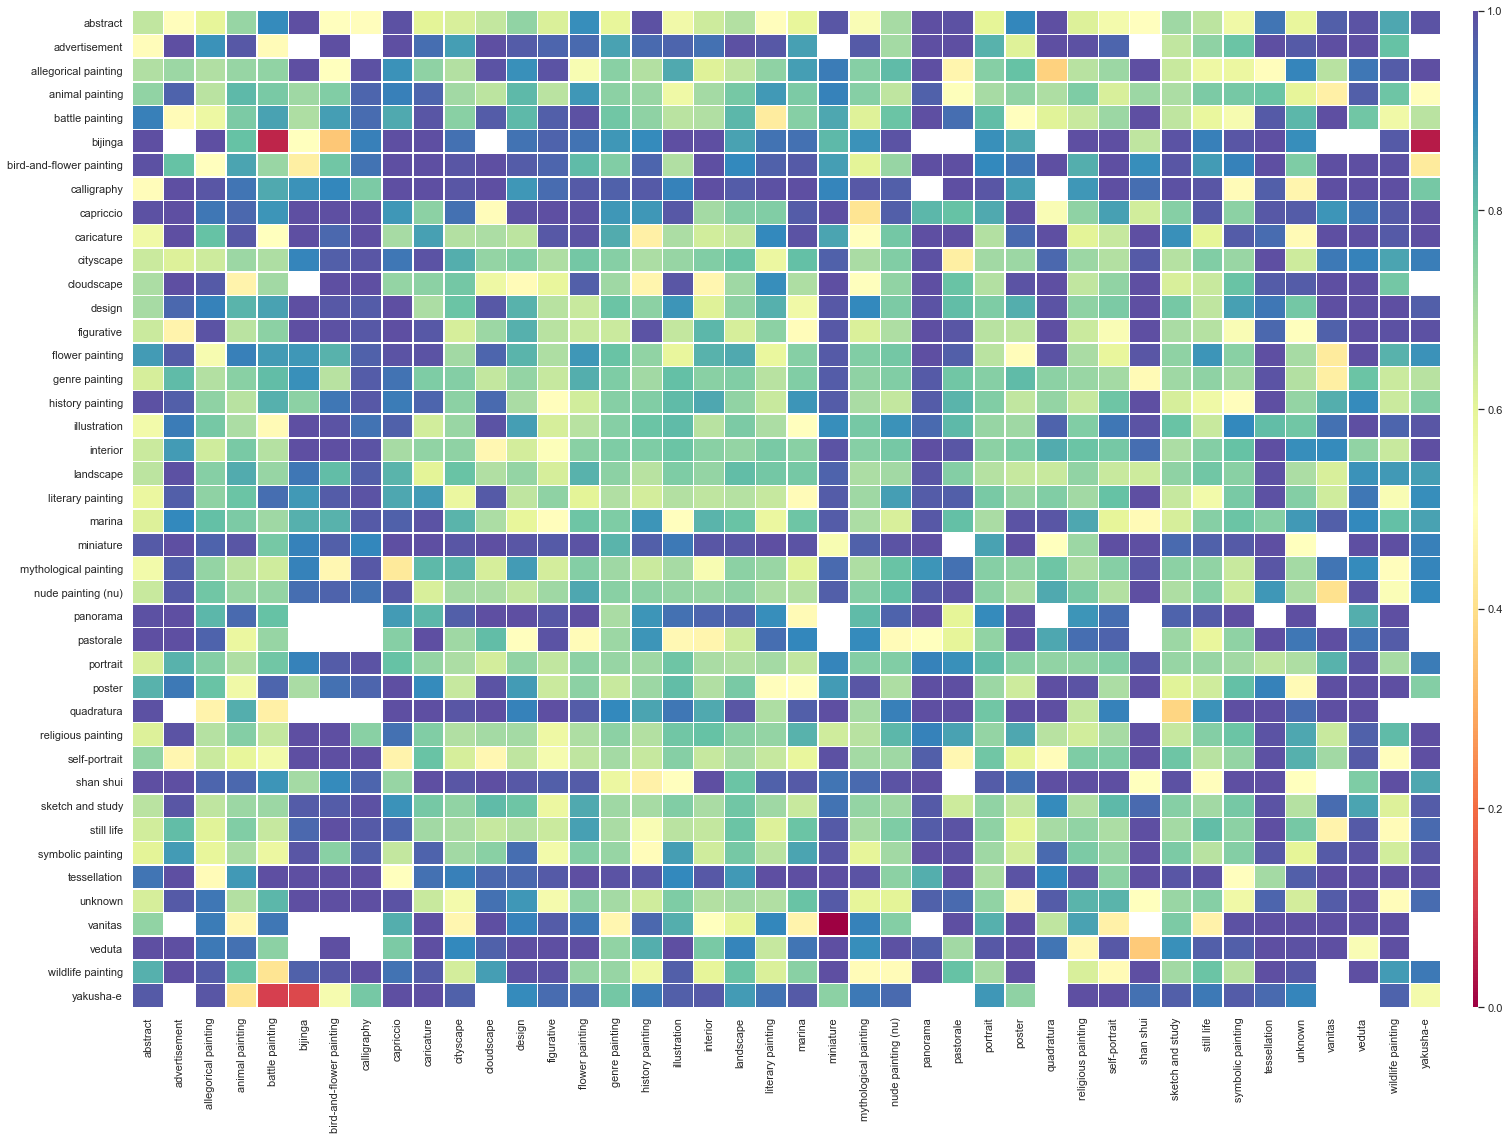

In [14]:
# Multi-task
plt.figure(figsize=(24, 16))
snb.heatmap(
    data=r_genre_genre.pivot('genre_x', 'genre_y', 'B. Acc.'), 
    annot=False, fmt='.0%', cmap="Spectral", cbar=True, linewidths=.5,
    vmin=0, vmax=1, center=0.5, cbar_kws={'aspect': 200, 'pad': 0.02})

plt.ylabel(None); plt.xlabel(None); plt.tight_layout();

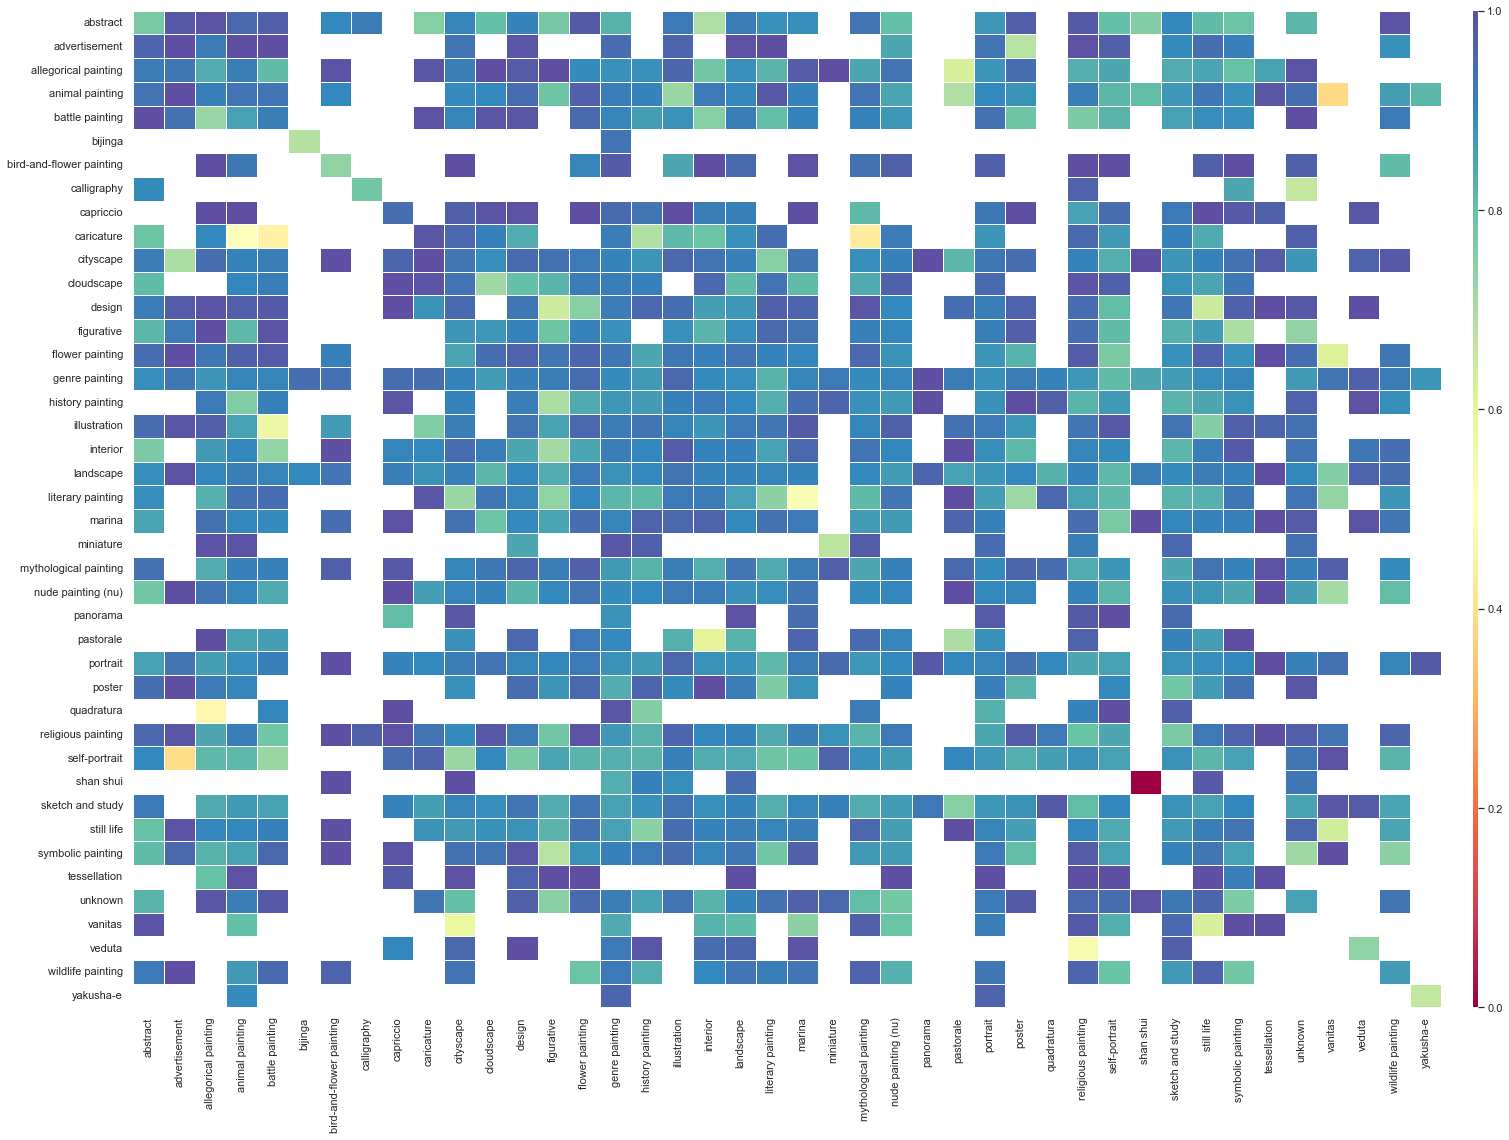

In [20]:
# Multi-label
plt.figure(figsize=(24, 16))
snb.heatmap(
    data=r_genre_genre.pivot('genre_x', 'genre_y', 'ROC AUC'), 
    annot=False, fmt='.0%', cmap="Spectral", cbar=True, linewidths=.5,
    vmin=0, vmax=1, center=0.5, cbar_kws={'aspect': 200, 'pad': 0.02})

plt.ylabel(None); plt.xlabel(None); plt.tight_layout();

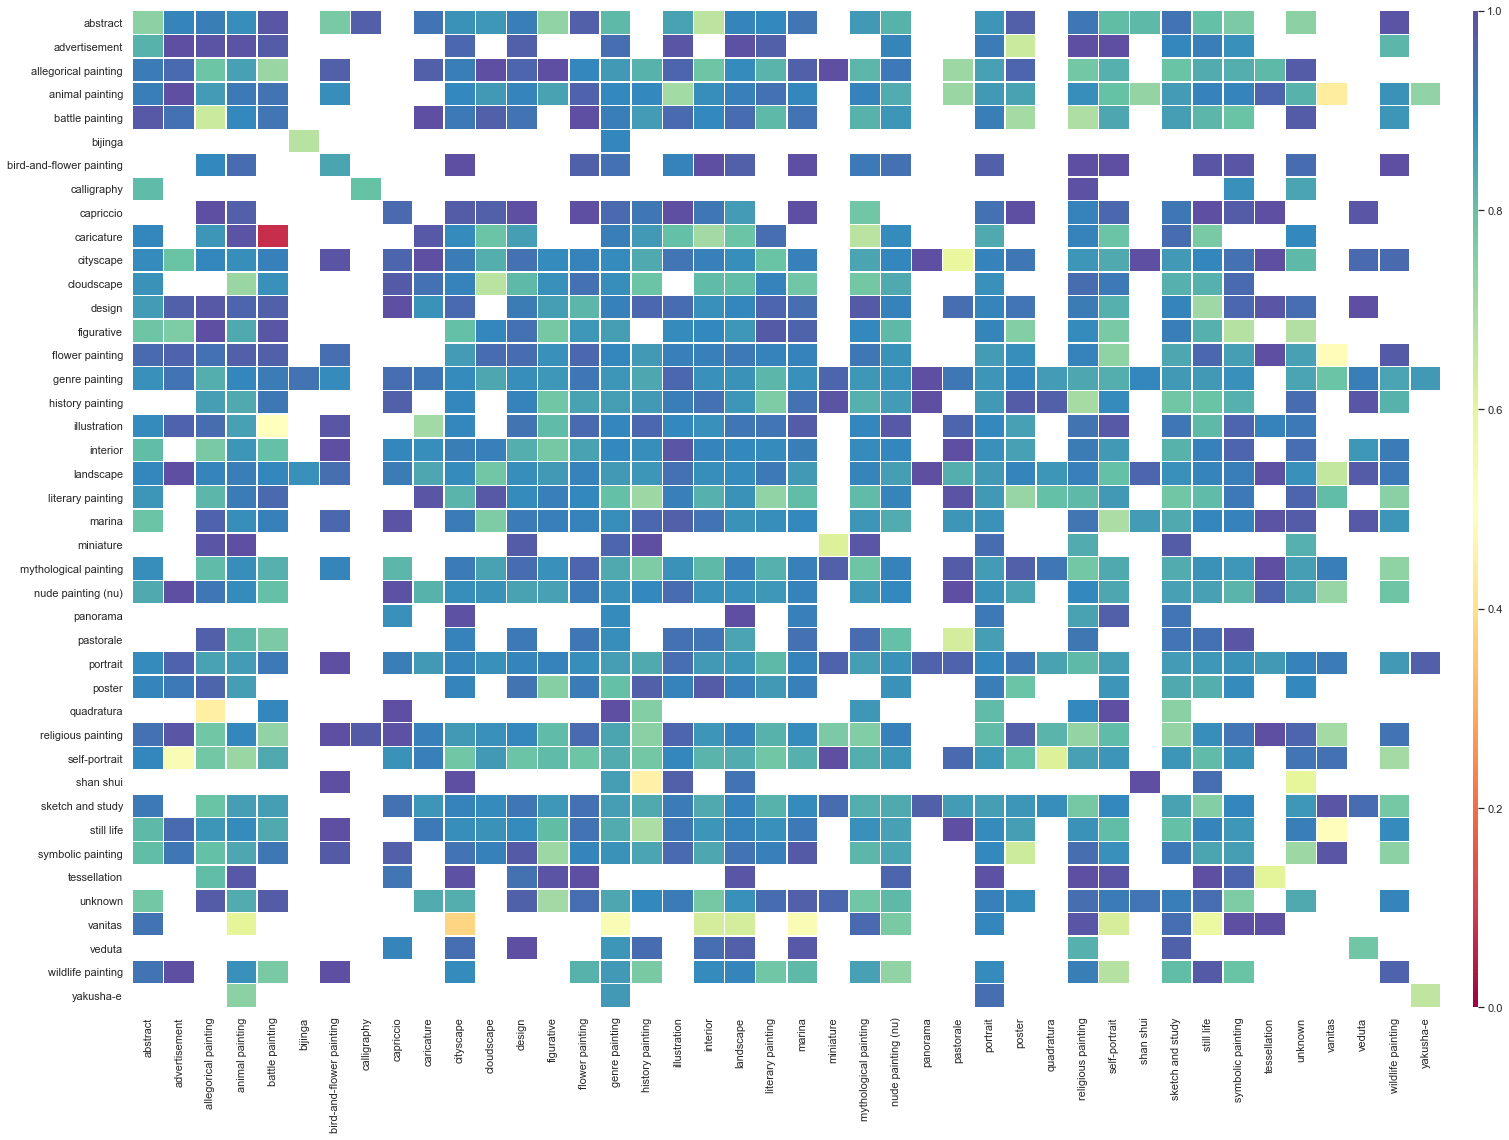

In [15]:
# Multi-task
plt.figure(figsize=(24, 16))
snb.heatmap(
    data=r_genre_genre.pivot('genre_x', 'genre_y', 'ROC AUC'), 
    annot=False, fmt='.0%', cmap="Spectral", cbar=True, linewidths=.5,
    vmin=0, vmax=1, center=0.5, cbar_kws={'aspect': 200, 'pad': 0.02})

plt.ylabel(None); plt.xlabel(None); plt.tight_layout();

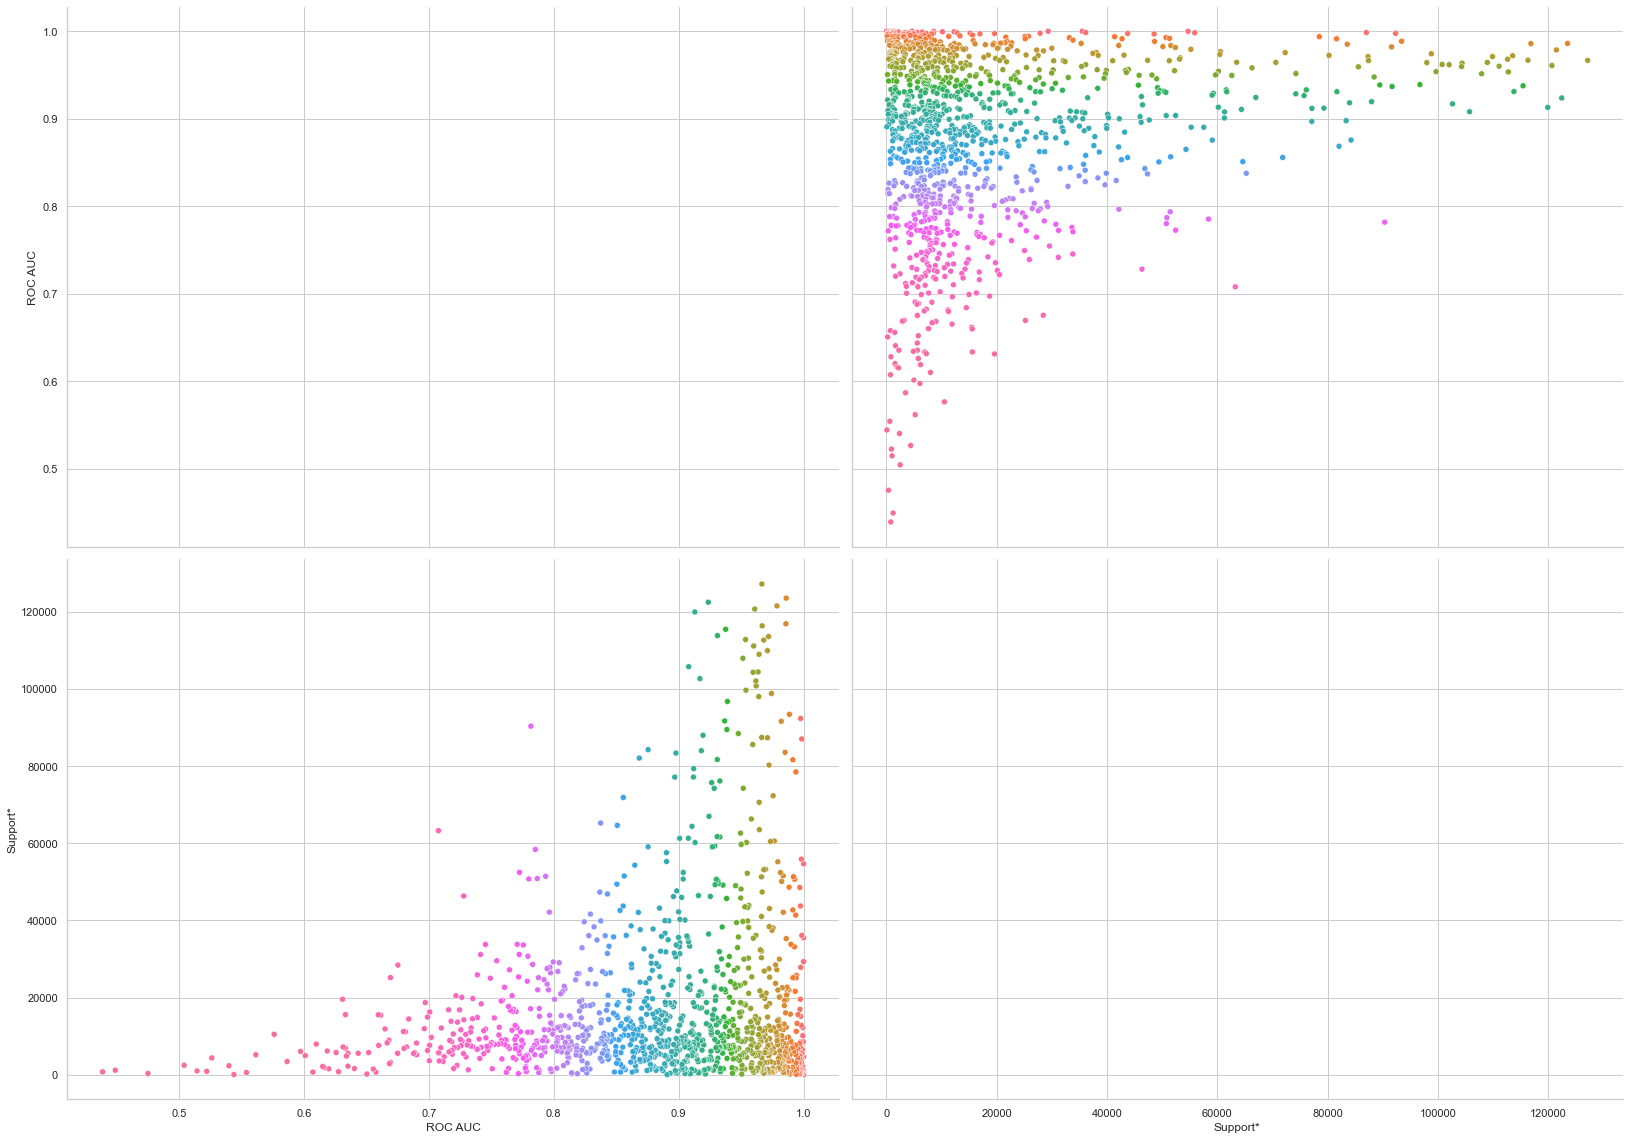

In [21]:
g = snb.pairplot(data=r_painter,
                 vars=['ROC AUC', 'Support*'],
                 hue='artist_name_x',
                 dropna=True, height=8)
g._legend.remove()
plt.tight_layout();

In [ ]:
del g, r_genre_style, r_painter_sampled, r_genre_genre, r_painter, r_style, r_genre, r_group, r_source, answer, z

## ROC AUC

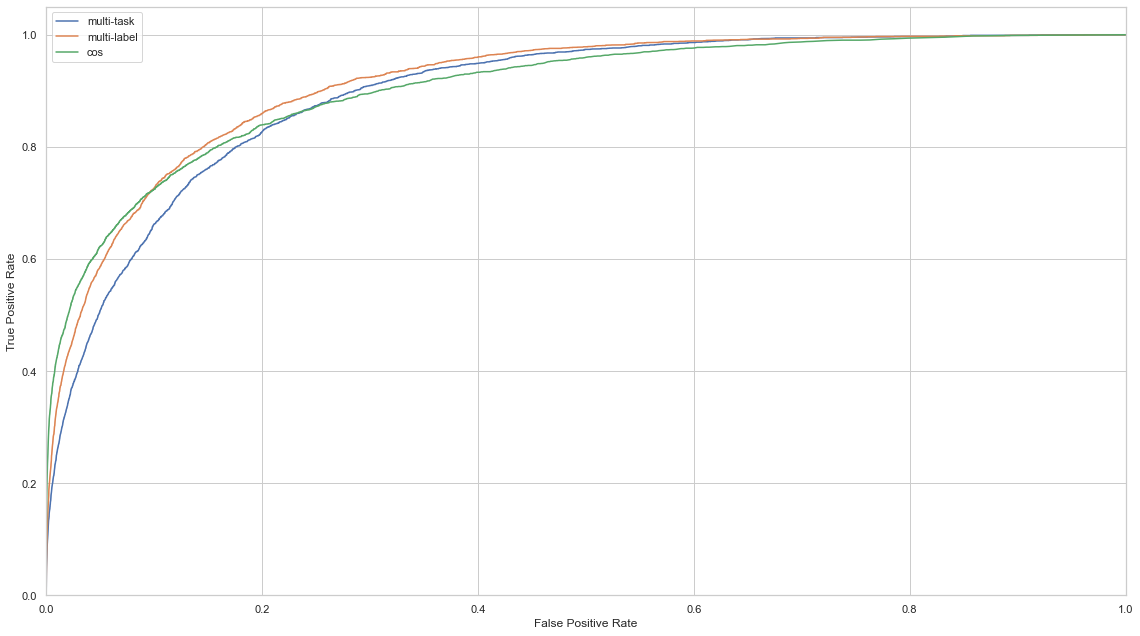

In [63]:
plt.figure(figsize=(16, 9))

s = np.random.rand(len(solution)) < 0.01

for filename in answers:
    a = pd.read_csv(filename)
    fpr, tpr, _ = metrics.roc_curve(solution.sameArtist[s], a.sameArtist[s])

    label = os.path.splitext(os.path.basename(filename))[0]
    snb.lineplot(x=fpr, y=tpr, label=label)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.tight_layout();

## Evaluating Answer

In [7]:
def confusion_matrix(y, c, tag):
    plt.figure()
    plt.title(f'Confusion Matrix {tag}')
    cm = metrics.confusion_matrix(y, c).astype('float')
    cm /= cm.sum(axis=1, keepdims=True)
    snb.heatmap(cm, cmap="YlGnBu", linewidths=.5, annot=True, fmt='.2f')
    
def _evaluate(y, p, c, tag):
    try:
        print('    ROC auc:', metrics.roc_auc_score(y, p))
        print(metrics.classification_report(y, c))
        confusion_matrix(y, c, tag)
        
        plt.figure(figsize=(16, 6))
        plt.title(f'Answer Distribution for {tag}')
        snb.distplot(p)
    except ValueError as e:
        print(e, file=sys.stderr)

In [8]:
def evaluate(answer_file):
    print(f'\nEvaluating answer file "{answer_file}"')
    answer = pd.read_csv(answer_file)['sameArtist']
    
    print('  General evaluation:')
    _evaluate(z['sameArtist'],
              answer,
              answer >= .5,
              answer_file)

    for tag in ['train_and_test', 'test_only']:
        print(f'  Evaluation of sub-group {tag}:')
        selected = z['artist_group_x'] == tag
        zs, answer_s = z[selected], answer[selected]
        _evaluate(zs['sameArtist'],
                  answer_s,
                  answer_s >= .5,
                  tag=answer_file)


Evaluating answer file "/work/painter-by-numbers/wlogs/generate-softmax-l2/5/answer.csv"
  General evaluation:
    ROC auc: 0.831379516462425
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.91  21628697
         1.0       0.05      0.64      0.09    287350

   micro avg       0.83      0.83      0.83  21916047
   macro avg       0.52      0.74      0.50  21916047
weighted avg       0.98      0.83      0.89  21916047

  Evaluation of sub-group train_and_test:
    ROC auc: 0.8459770277111891
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.90  18974410
         1.0       0.05      0.68      0.09    245917

   micro avg       0.82      0.82      0.82  19220327
   macro avg       0.52      0.75      0.50  19220327
weighted avg       0.98      0.82      0.89  19220327

  Evaluation of sub-group test_only:
    ROC auc: 0.7606679740859006
              precision    recall  f1-score   support

     

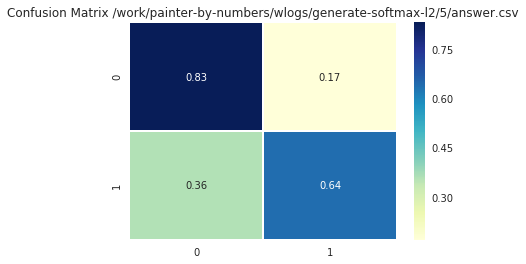

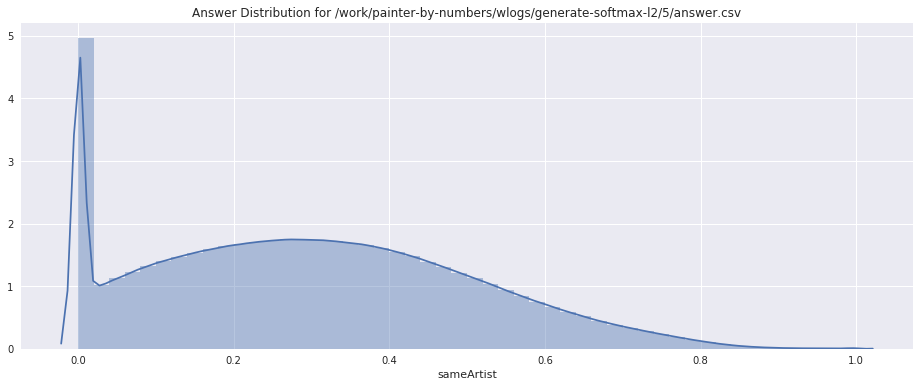

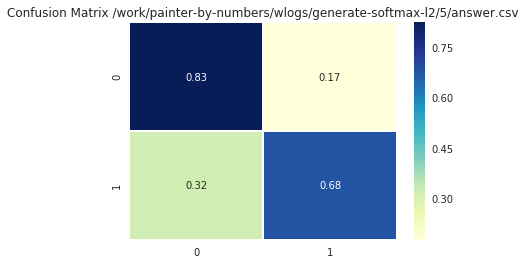

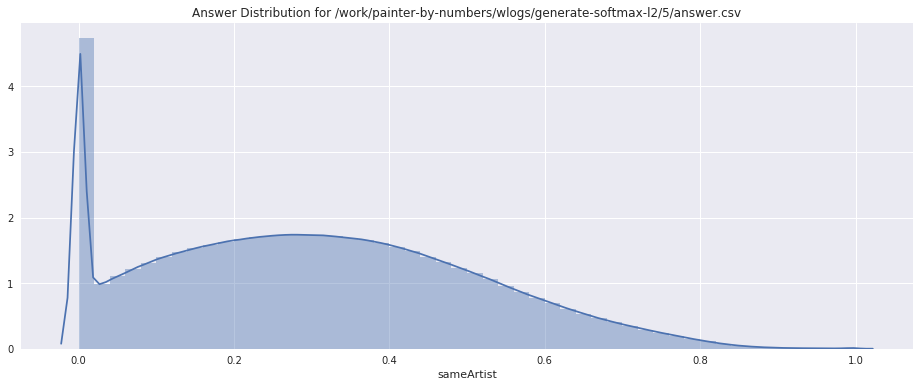

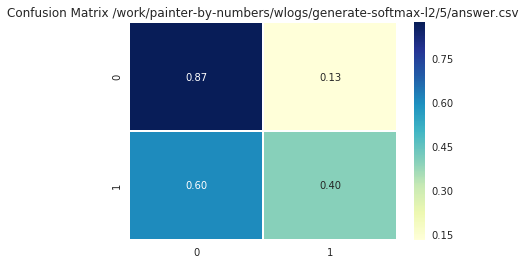

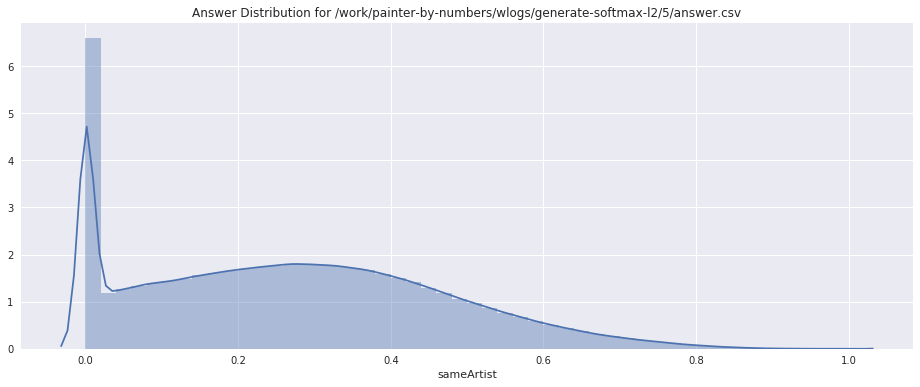

In [10]:
evaluate(answers[0])


Evaluating answer file "/work/painter-by-numbers/wlogs/generate-softmax-sigmoid/1/answer.csv"
  General evaluation:
    ROC auc: 0.8655822327688744
              precision    recall  f1-score   support

         0.0       1.00      0.76      0.86  21628697
         1.0       0.04      0.80      0.08    287350

   micro avg       0.76      0.76      0.76  21916047
   macro avg       0.52      0.78      0.47  21916047
weighted avg       0.98      0.76      0.85  21916047

  Evaluation of sub-group train_and_test:
    ROC auc: 0.8785606827122966
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86  18974410
         1.0       0.04      0.83      0.08    245917

   micro avg       0.76      0.76      0.76  19220327
   macro avg       0.52      0.79      0.47  19220327
weighted avg       0.98      0.76      0.85  19220327

  Evaluation of sub-group test_only:
    ROC auc: 0.7971153054154531
              precision    recall  f1-score   support


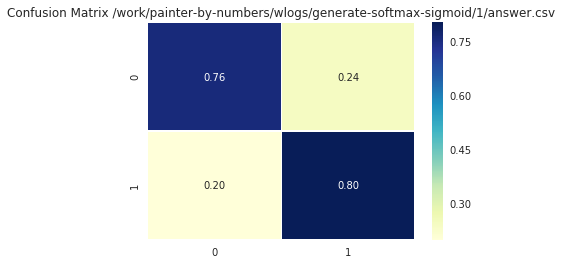

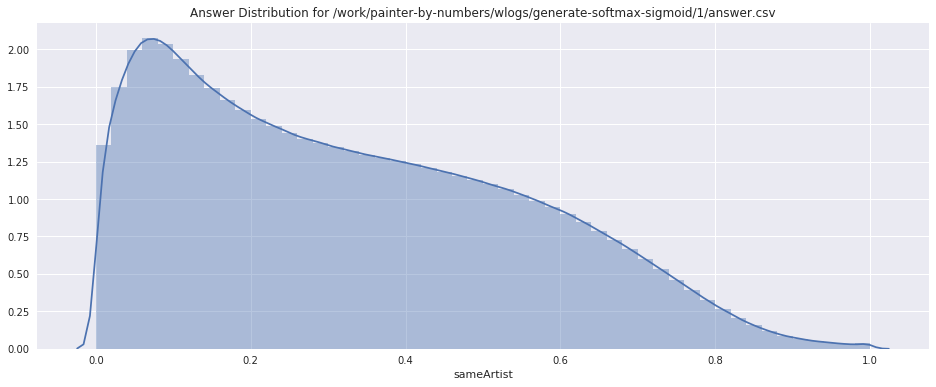

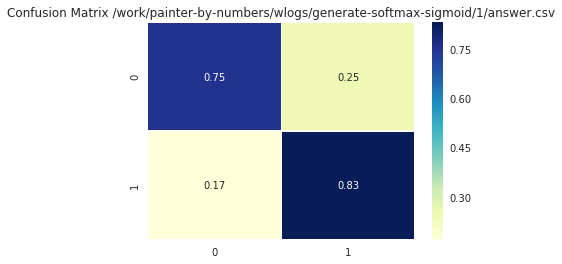

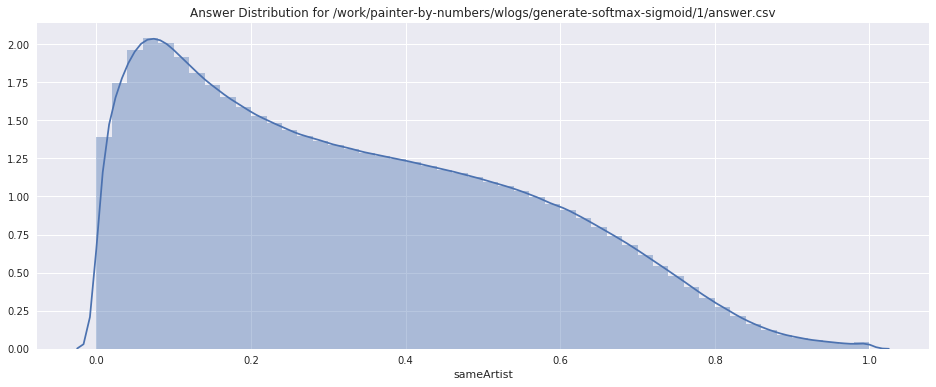

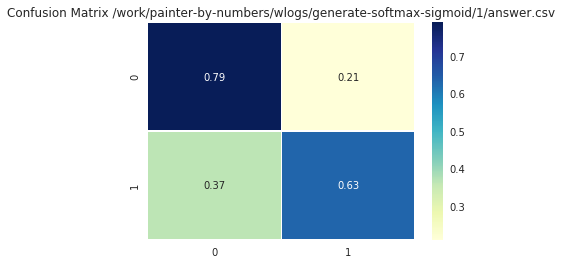

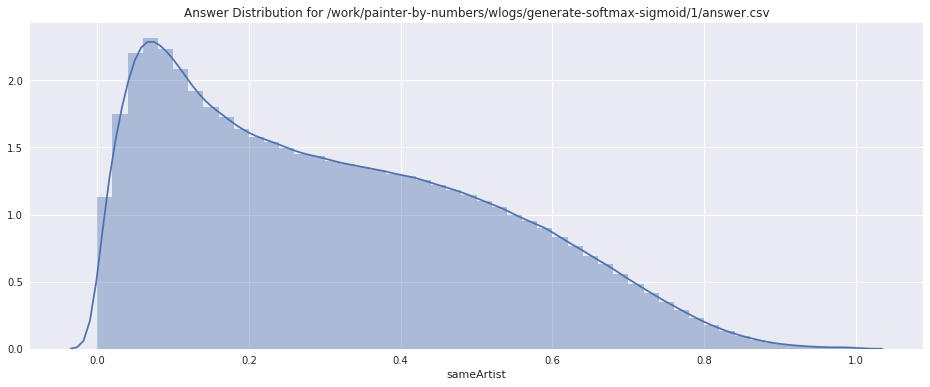

In [11]:
evaluate(answers[1])

In [12]:
evaluate(answers[2])


Evaluating answer file "/work/painter-by-numbers/dl-08/painter-by-numbers/wlogs/answer-sigmoid-1024/1/answer-mean.csv"
  General evaluation:


Found input variables with inconsistent numbers of samples: [21916047, 4312670]


  Evaluation of sub-group train_and_test:


Found input variables with inconsistent numbers of samples: [19220327, 3782006]


  Evaluation of sub-group test_only:


Found input variables with inconsistent numbers of samples: [2695720, 530664]



Evaluating answer file "/work/painter-by-numbers/dl-08/painter-by-numbers/wlogs/answer/7/answer-mean.csv"
  General evaluation:
    ROC auc: 0.8976920592027495
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95  21628697
         1.0       0.09      0.63      0.16    287350

   micro avg       0.91      0.91      0.91  21916047
   macro avg       0.54      0.77      0.56  21916047
weighted avg       0.98      0.91      0.94  21916047

  Evaluation of sub-group train_and_test:
    ROC auc: 0.908329330724609
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.95  18974410
         1.0       0.09      0.67      0.16    245917

   micro avg       0.91      0.91      0.91  19220327
   macro avg       0.54      0.79      0.56  19220327
weighted avg       0.98      0.91      0.94  19220327

  Evaluation of sub-group test_only:
    ROC auc: 0.8331335237551588
              precision    recall  f1-score

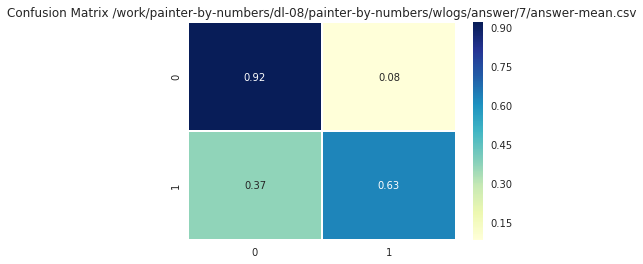

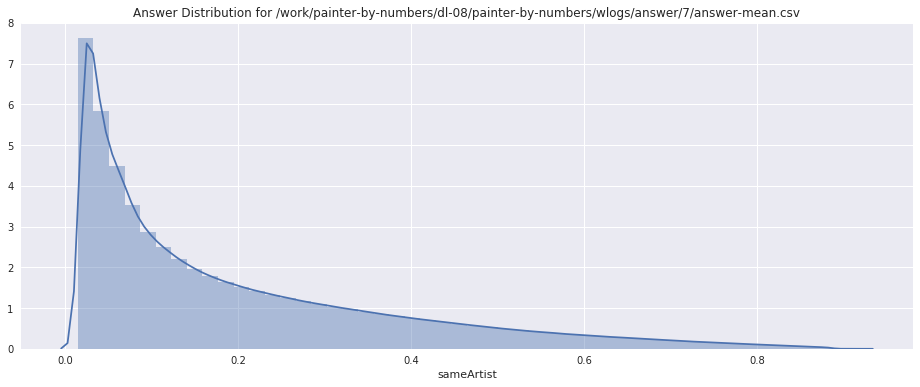

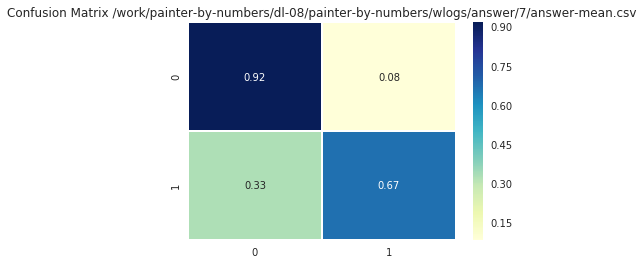

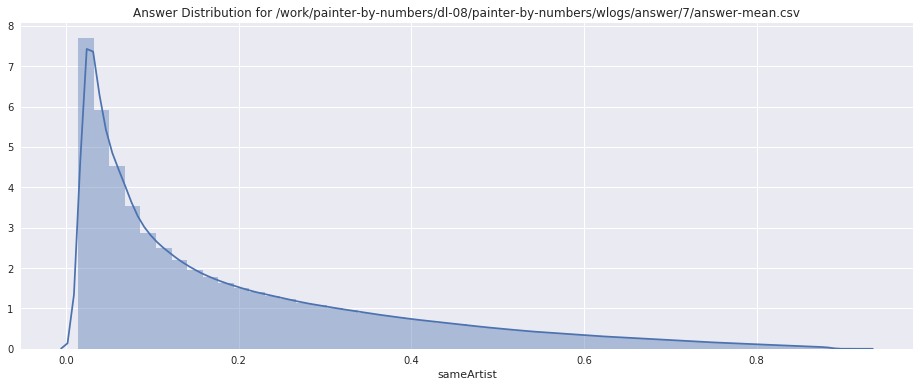

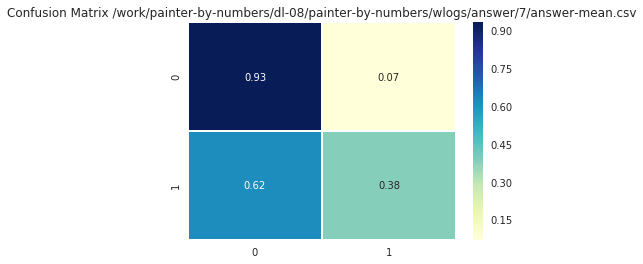

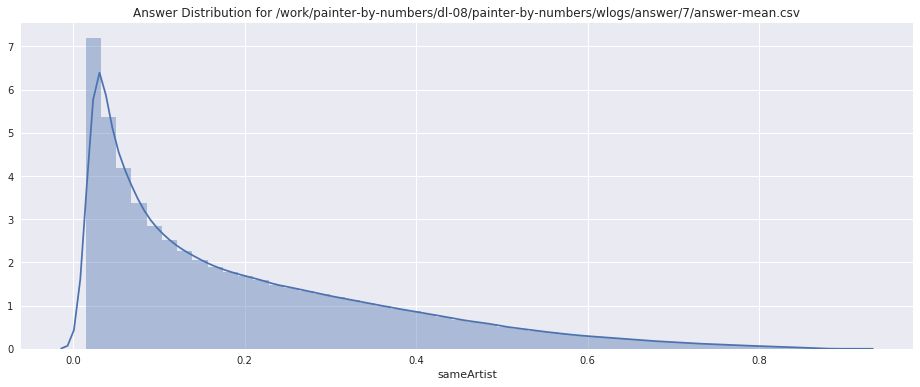

In [13]:
evaluate(answers[3])


Evaluating answer file "/work/painter-by-numbers/answers/pbn_random_299_inception_1763_answer.csv"
  General evaluation:
    ROC auc: 0.8508314141255108
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99  21628697
         1.0       0.19      0.07      0.10    287350

   micro avg       0.98      0.98      0.98  21916047
   macro avg       0.59      0.53      0.55  21916047
weighted avg       0.98      0.98      0.98  21916047

  Evaluation of sub-group train_and_test:
    ROC auc: 0.8592352304235075
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99  18974410
         1.0       0.21      0.07      0.10    245917

   micro avg       0.98      0.98      0.98  19220327
   macro avg       0.60      0.53      0.55  19220327
weighted avg       0.98      0.98      0.98  19220327

  Evaluation of sub-group test_only:
    ROC auc: 0.7938571047128536
              precision    recall  f1-score   sup

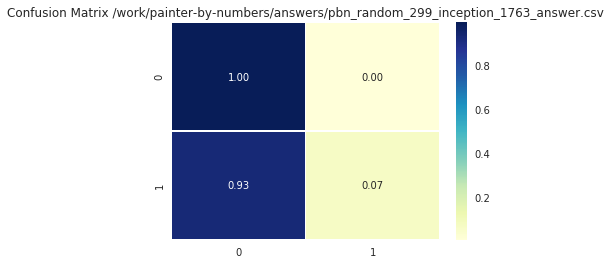

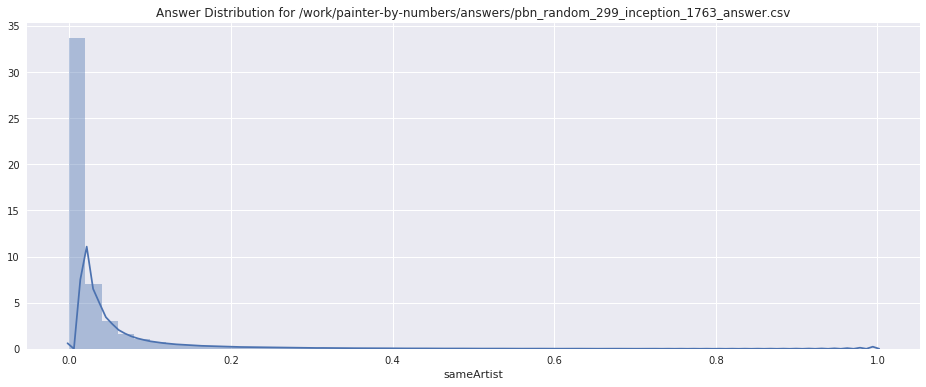

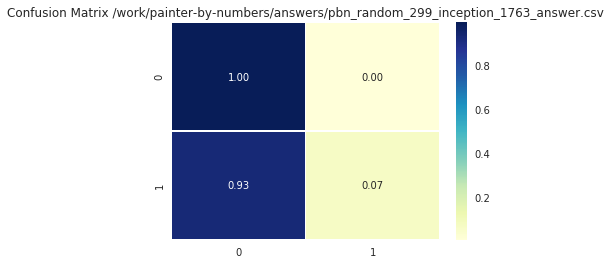

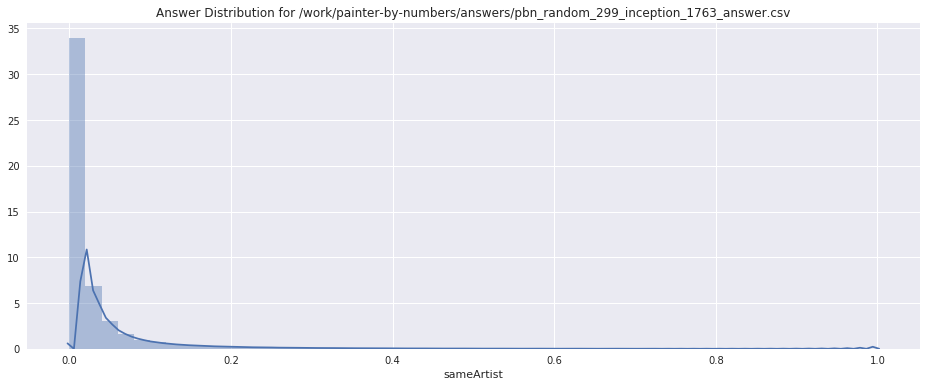

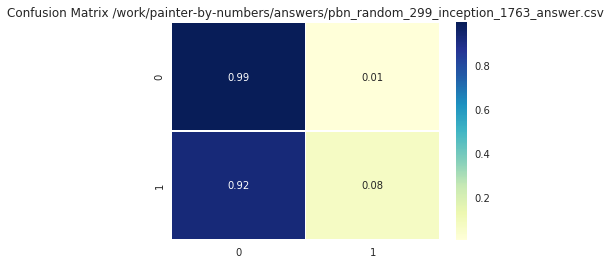

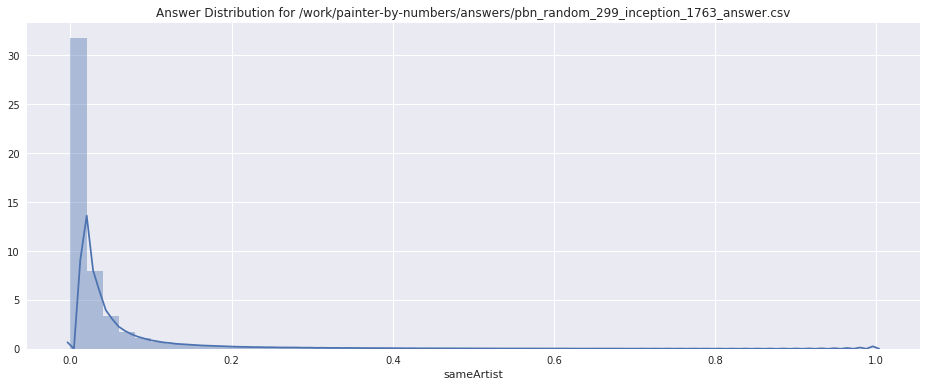

In [10]:
evaluate(answers[4])


Evaluating answer file "/work/painter-by-numbers/answers/answer-1763-sigmoid-sigmoid.csv"
  General evaluation:
    ROC auc: 0.9134064387376993
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96  21628697
         1.0       0.11      0.67      0.19    287350

   micro avg       0.92      0.92      0.92  21916047
   macro avg       0.55      0.80      0.57  21916047
weighted avg       0.98      0.92      0.95  21916047

  Evaluation of sub-group train_and_test:
    ROC auc: 0.922494895765783
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96  18974410
         1.0       0.11      0.70      0.19    245917

   micro avg       0.92      0.92      0.92  19220327
   macro avg       0.55      0.81      0.58  19220327
weighted avg       0.98      0.92      0.95  19220327

  Evaluation of sub-group test_only:
    ROC auc: 0.8576843641792131
              precision    recall  f1-score   support

    

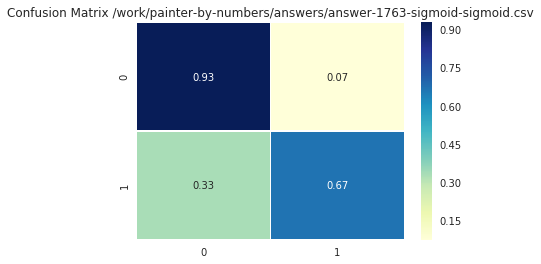

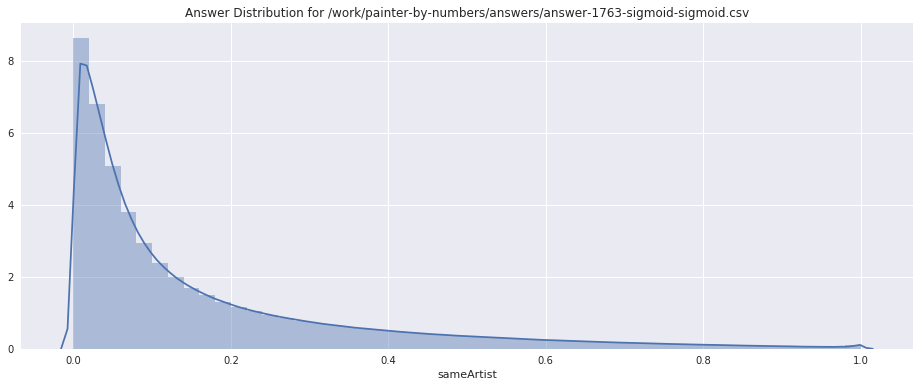

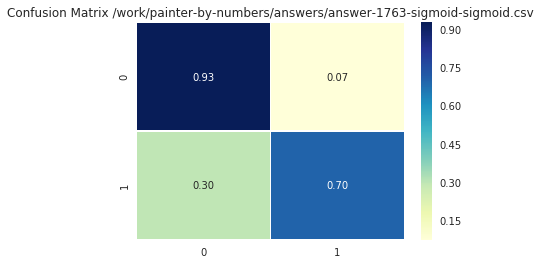

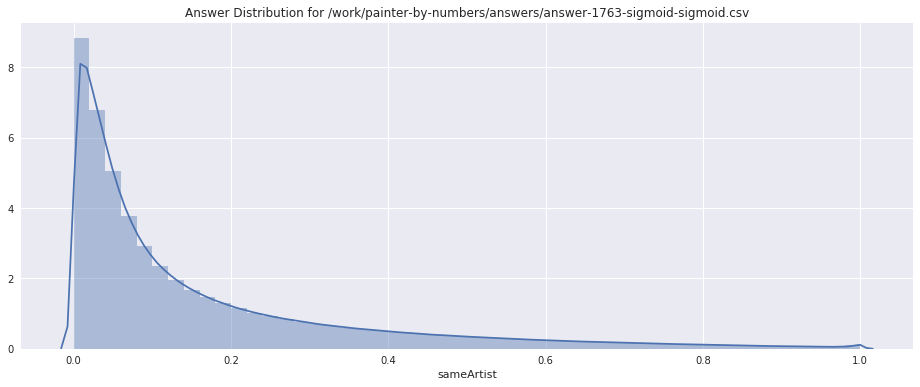

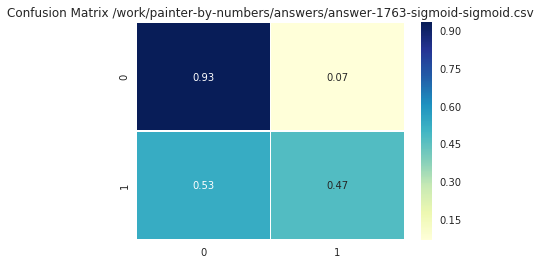

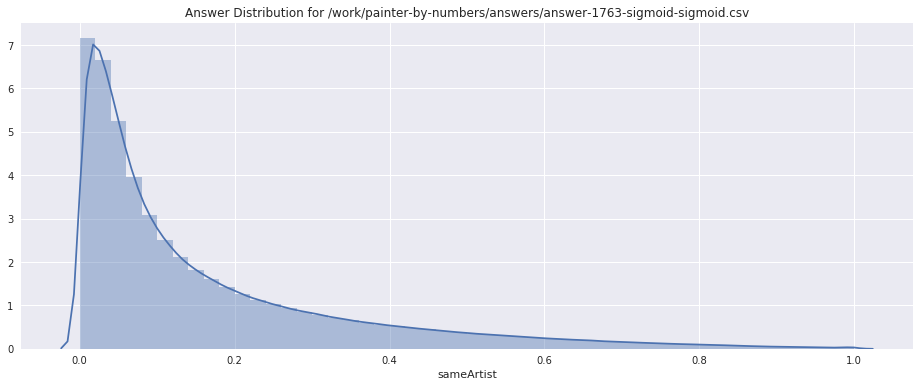

In [14]:
evaluate(answers[6])


Evaluating answer file "/work/painter-by-numbers/answers/inceptionv3-dot.csv"
  General evaluation:
    ROC auc: 0.9027554714345303
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99  21628697
         1.0       0.95      0.09      0.16    287350

   micro avg       0.99      0.99      0.99  21916047
   macro avg       0.97      0.54      0.58  21916047
weighted avg       0.99      0.99      0.98  21916047

  Evaluation of sub-group train_and_test:
    ROC auc: 0.921466379370936
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99  18974410
         1.0       0.96      0.10      0.19    245917

   micro avg       0.99      0.99      0.99  19220327
   macro avg       0.97      0.55      0.59  19220327
weighted avg       0.99      0.99      0.98  19220327

  Evaluation of sub-group test_only:
    ROC auc: 0.7959725810210776
              precision    recall  f1-score   support

         0.0    

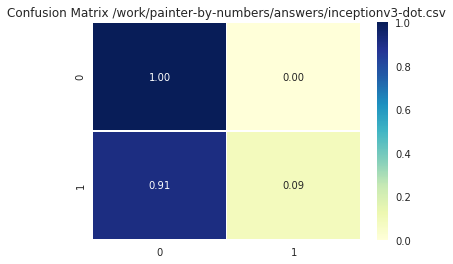

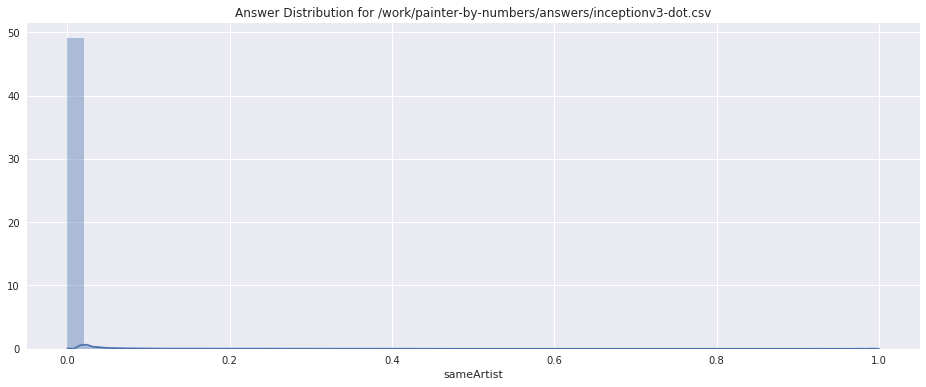

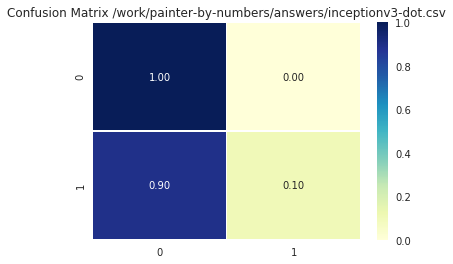

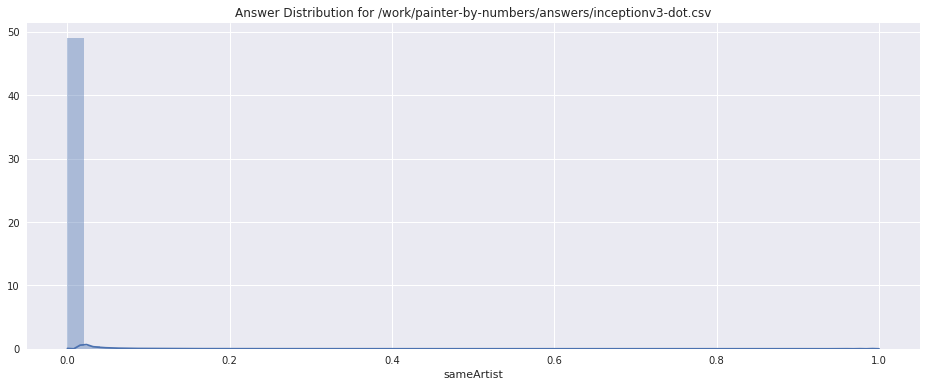

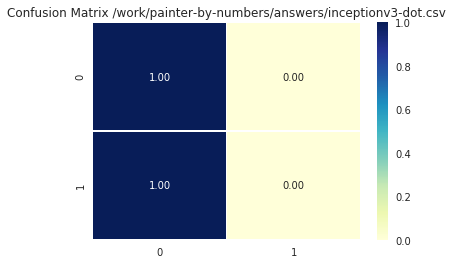

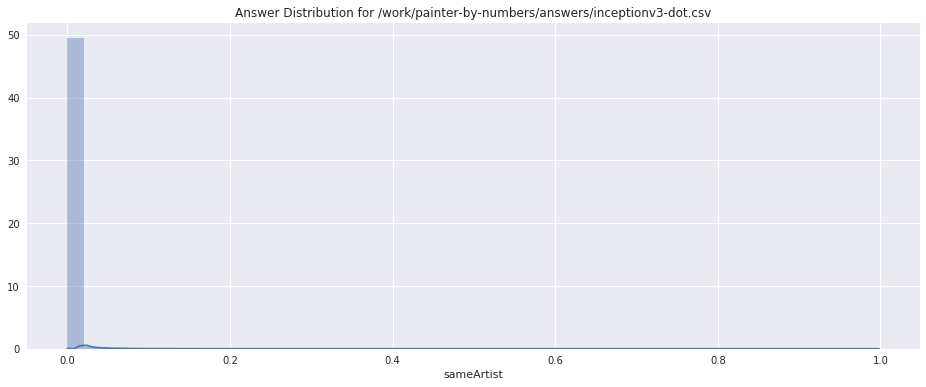

In [16]:
evaluate(answers[7])

VGG Gram Matrix -> Dense -> Sigmoid

Evaluating answer file "/work/painter-by-numbers/wlogs/gram-200/answer/answer.csv"
  General evaluation:
    ROC auc: 0.6136511289278946
              precision    recall  f1-score   support

         0.0       0.99      0.63      0.77  21628697
         1.0       0.02      0.53      0.04    287350

   micro avg       0.62      0.62      0.62  21916047
   macro avg       0.50      0.58      0.40  21916047
weighted avg       0.98      0.62      0.76  21916047

  Evaluation of sub-group train_and_test:
    ROC auc: 0.6126729270949687
              precision    recall  f1-score   support

         0.0       0.99      0.63      0.77  18974410
         1.0       0.02      0.53      0.03    245917

   micro avg       0.62      0.62      0.62  19220327
   macro avg       0.50      0.58      0.40  19220327
weighted avg       0.98      0.62      0.76  19220327

  Evaluation of sub-group test_only:
    ROC auc: 0.620030848653964
              precision    rec

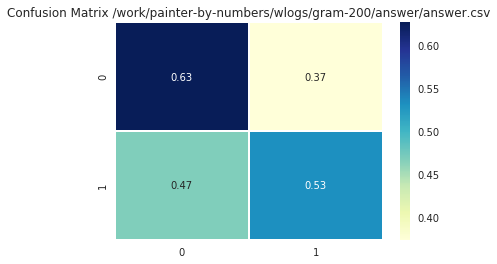

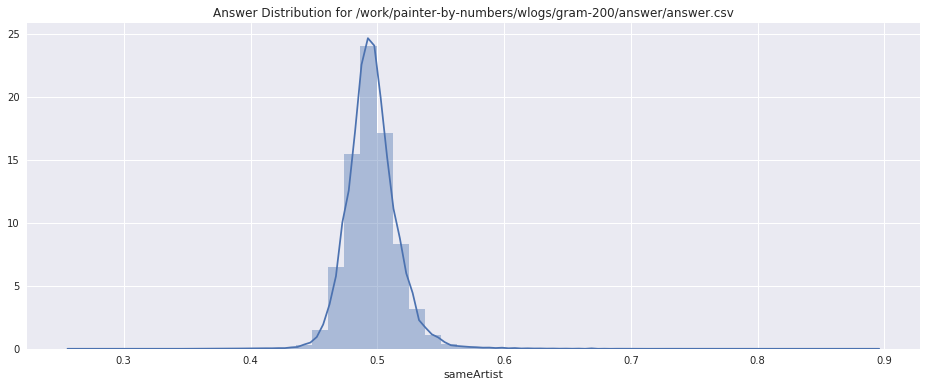

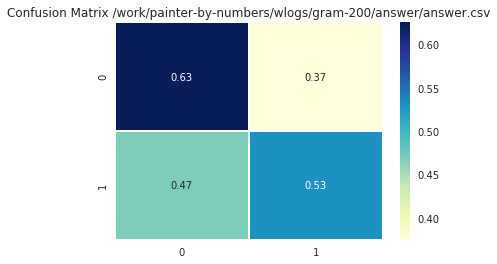

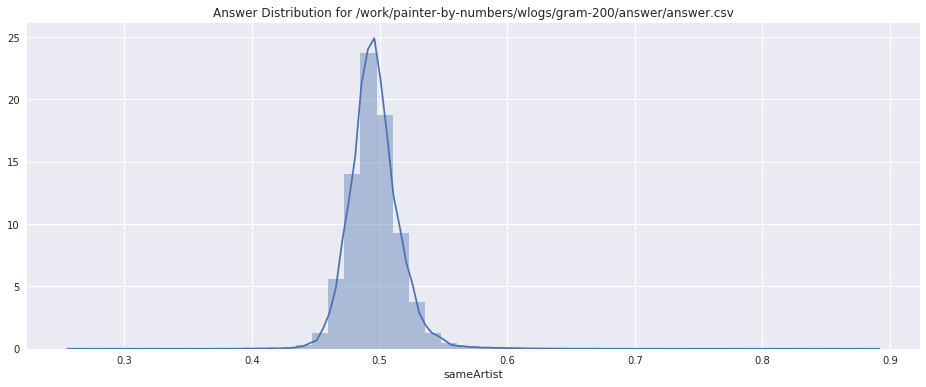

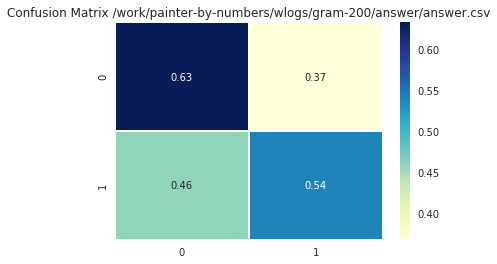

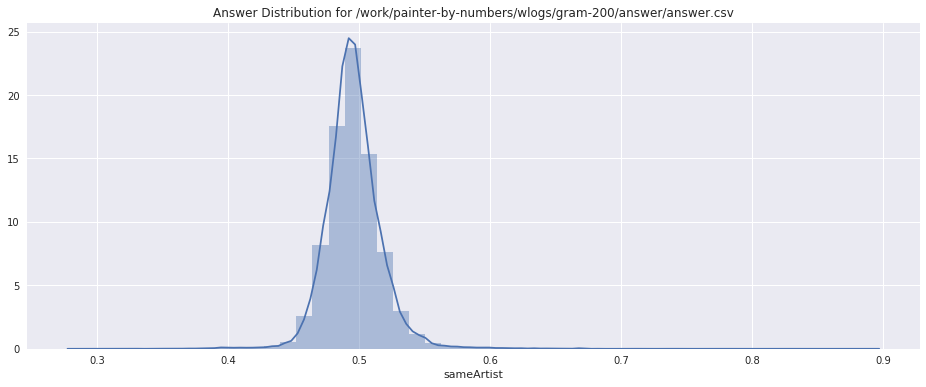

In [10]:
print('VGG Gram Matrix -> Dense -> Sigmoid')
evaluate(answers[8])